# Train the neural network

In [3]:
# Uncomment the following line if matplotlib is not installed.
# !pip install matplotlib

from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt
from time import time

## 1. Get data

The Goal is to classify clothing types.<br>
The dataset can be automatically downloaded through Gluon’s data.vision.datasets module. The following code downloads the training dataset and shows the first example.

In [4]:
mnist_train = datasets.FashionMNIST(train=True)
mnist_train

### Labels

Each training and test example is assigned to one of the following labels:

| Label  | Description  |
|---|---|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [5]:
X, y = mnist_train[0] #train set

In [6]:
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

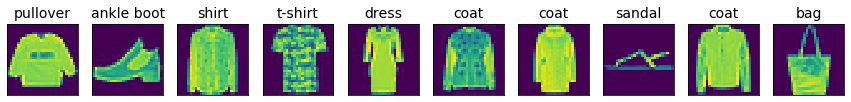

In [7]:
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]
X, y = mnist_train[0:10]
# plot images
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In order to feed data into a Gluon model, we need to convert the images to the (channel, height, width) format with a floating point data type. It can be done by transforms.ToTensor.

In [8]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

mnist_train = mnist_train.transform_first(transformer)

In order to use it in training, we need to get a (randomized) batch of examples. It can be easily done by <span style="color:red">gluon.data.DataLoader.</span> Here we use four works to process data in parallel, which is often necessary especially for complex data transforms.

In [9]:
batch_size = 256

train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [10]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/chatbot/anaconda3/envs/mxnet/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/chatbot/anaconda3/envs/mxnet/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chatbot/anaconda3/envs/mxnet/lib/python3.6/site-packages/mxnet/gluon/data/dataloader.py", line 175, in fetcher_loop
    idx, batch = data_queue.get()
  File "/home/chatbot/anaconda3/envs/mxnet/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/chatbot/anaconda3/envs/mxnet/lib/python3.6/site-packages/mxnet/gluon/data/dataloader.py", line 56, in rebuild_ndarray
    fd = fd.detach()
  File "/home/chatbot/anaconda3/envs/mxnet/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/chatbot/anaconda3/envs/mxnet/lib/python

In [7]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=4)

## 2. Define the model

We reimplement the same LeNet introduced before. One difference here is that we changed the weight initialization method to Xavier, which is a popular choice for deep convolutional neural networks.

In [8]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
net.initialize(init=init.Xavier())

In [9]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## 3. Train

In [11]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

In [12]:
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)

    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)

    print("Epoch %d: Loss: %.3f, Train acc %.3f, Test acc %.3f, \
Time %.1f sec" % (
        epoch, train_loss/len(train_data),
        train_acc/len(train_data),
        valid_acc/len(valid_data), time()-tic))

Epoch 0: Loss: 0.831, Train acc 0.696, Test acc 0.804, Time 13.3 sec
Epoch 1: Loss: 0.465, Train acc 0.827, Test acc 0.854, Time 12.7 sec
Epoch 2: Loss: 0.395, Train acc 0.853, Test acc 0.865, Time 12.7 sec
Epoch 3: Loss: 0.359, Train acc 0.867, Test acc 0.881, Time 13.0 sec
Epoch 4: Loss: 0.333, Train acc 0.878, Test acc 0.886, Time 13.6 sec
Epoch 5: Loss: 0.321, Train acc 0.883, Test acc 0.879, Time 13.1 sec
Epoch 6: Loss: 0.303, Train acc 0.888, Test acc 0.889, Time 12.6 sec
Epoch 7: Loss: 0.290, Train acc 0.892, Test acc 0.887, Time 12.8 sec
Epoch 8: Loss: 0.279, Train acc 0.896, Test acc 0.896, Time 13.9 sec
Epoch 9: Loss: 0.271, Train acc 0.898, Test acc 0.896, Time 13.2 sec


## 4. Save the model

In [13]:
net.save_parameters('net.params')